In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [3]:
df = pd.read_excel('premiums_rest.xlsx')

In [5]:
# We don't have genetical data for this data but since we added for young people, just for simplicity
# and concistency while deploying model we will add one column here as well with value 0

In [6]:
df['genetical_risk'] = 0

In [7]:
df.head()

,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


In [8]:
df.shape

(29904, 14)

In [9]:
df.columns

Index(['Age', 'Gender', 'Region', 'Marital_status', 'Number Of Dependants',
       'BMI_Category', 'Smoking_Status', 'Employment_Status', 'Income_Level',
       'Income_Lakhs', 'Medical History', 'Insurance_Plan',
       'Annual_Premium_Amount', 'genetical_risk'],
      dtype='object')

In [10]:
df.columns.str.replace(' ','_').str.lower()

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

In [11]:
df.columns = df.columns.str.replace(' ','_').str.lower()

In [12]:
df.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

### Handling NA values

In [13]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           9
employment_status        1
income_level             9
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [14]:
df = df.dropna()

In [15]:
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

In [16]:
df.shape

(29886, 14)

### Handling duplicate values

In [17]:
df.duplicated().sum()

0

In [18]:
df  = df.drop_duplicates()

In [19]:
df.duplicated().value_counts()

False    29886
Name: count, dtype: int64

In [20]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.379910,23.364184,20892.303821,0.0
std,13.412657,1.431201,24.740339,6936.813440,0.0
min,26.000000,-3.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


In [21]:
df[df['number_of_dependants']<0].shape

(50, 14)

In [22]:
df[df['number_of_dependants']<0]['number_of_dependants'].unique()

array([-1, -3])

In [23]:
### it seems like by mistake they were marked as negative but should have been positive

In [24]:
df['number_of_dependants'] = abs(df['number_of_dependants'])

In [25]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29886.000000,29886.000000,29886.000000,29886.000000,29886.0
mean,43.396105,2.385933,23.364184,20892.303821,0.0
std,13.412657,1.421137,24.740339,6936.813440,0.0
min,26.000000,0.000000,1.000000,3625.000000,0.0
25%,34.000000,1.000000,7.000000,15697.250000,0.0
50%,42.000000,3.000000,17.000000,20489.000000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,356.000000,5.000000,930.000000,43471.000000,0.0


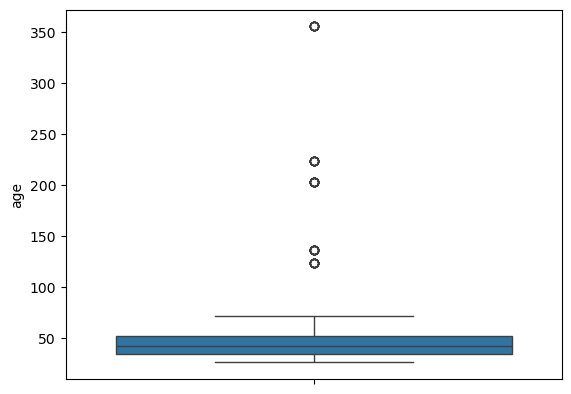

In [26]:
sns.boxplot(df['age'])
plt.show()

In [27]:
num_columns = df.select_dtypes(include = np.number).columns

In [28]:
num_columns

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount',
       'genetical_risk'],
      dtype='object')

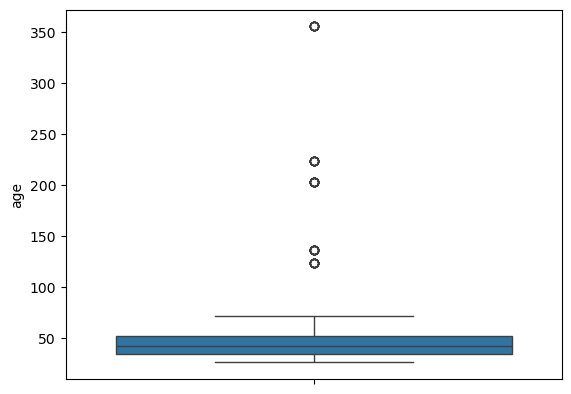

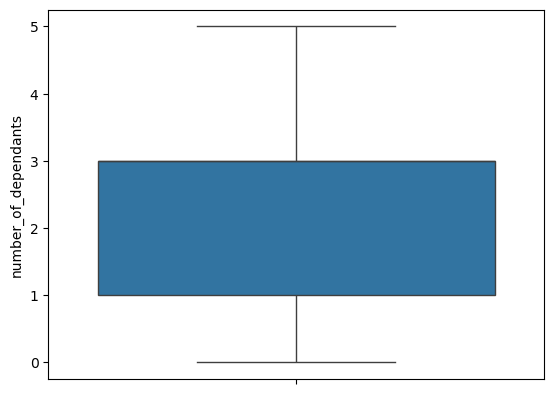

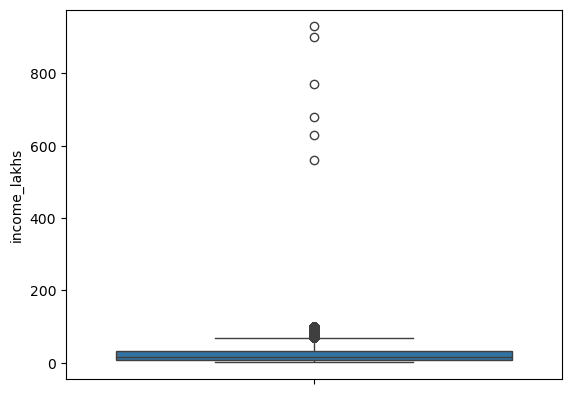

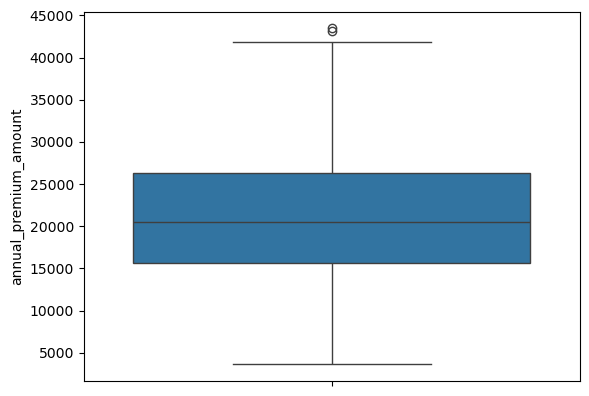

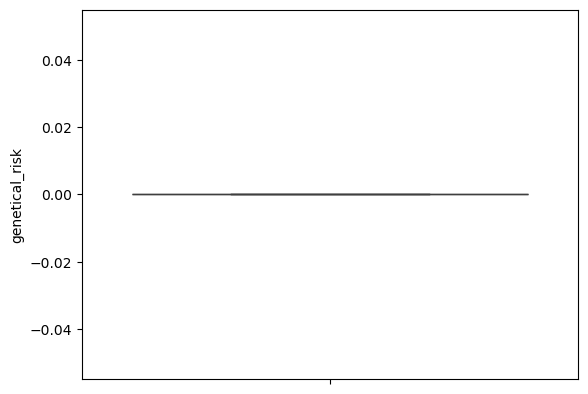

In [29]:
for col in num_columns:
    sns.boxplot(df[col])
    plt.show()

In [30]:
# with common knowledge and discussion with business we can take 100 as a threshold for age

In [31]:
df[df['age']>100]['age'].unique()

array([224, 124, 136, 203, 356])

In [32]:
df1 = df[df['age'] <= 100].copy()

In [33]:
df1.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0


In [34]:
df1.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29828.000000,29828.000000,29828.000000,29828.000000,29828.0
mean,43.095380,2.387790,23.371530,20901.900563,0.0
std,11.041991,1.420641,24.751262,6928.457636,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15706.000000,0.0
50%,42.000000,3.000000,17.000000,20496.000000,0.0
75%,52.000000,3.000000,32.000000,26361.000000,0.0
max,72.000000,5.000000,930.000000,43471.000000,0.0


<Axes: xlabel='income_lakhs', ylabel='Count'>

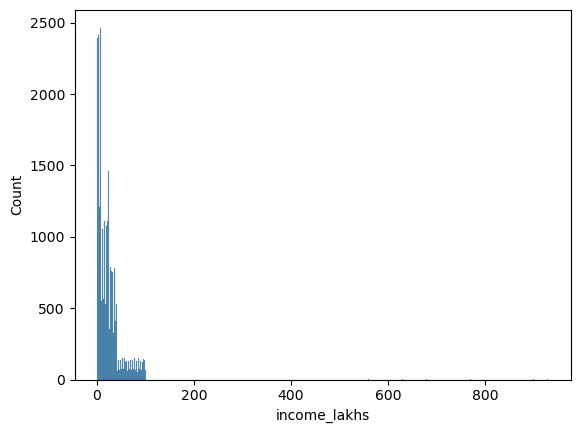

In [35]:
sns.histplot(df1['income_lakhs'])

In [36]:
df['income_lakhs'].quantile(.50)

17.0

In [37]:
def get_iqr_bounds(data,col):
    q1,q3 = data[col].quantile([.25,.75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5* iqr
    return lower_bound,upper_bound

In [38]:
get_iqr_bounds(df1,'income_lakhs')

(-30.5, 69.5)

In [39]:
df1['income_lakhs'].quantile(.999)

100.0

In [40]:
# it is not necessary to use iqr always, discuss with business and try to find a good threshold, here after discussing with business 100 seemed fine


In [41]:
df1[df1['income_lakhs']>100]['income_lakhs'].shape

(6,)

In [42]:
# only 10 are there, so we can safely remove them

In [43]:
df2 = df1[df1['income_lakhs']<= 100].copy()

<Axes: xlabel='income_lakhs', ylabel='Count'>

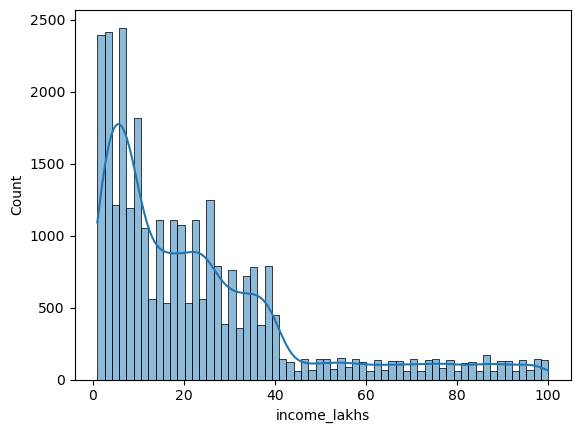

In [44]:
sns.histplot(df2['income_lakhs'],kde = True)

In [45]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.0
mean,43.094896,2.387734,23.226343,20900.689223,0.0
std,11.042430,1.420644,22.455408,6928.192115,0.0
min,26.000000,0.000000,1.000000,6538.000000,0.0
25%,34.000000,1.000000,7.000000,15705.250000,0.0
50%,42.000000,3.000000,17.000000,20495.500000,0.0
75%,52.000000,3.000000,32.000000,26360.000000,0.0
max,72.000000,5.000000,100.000000,43471.000000,0.0


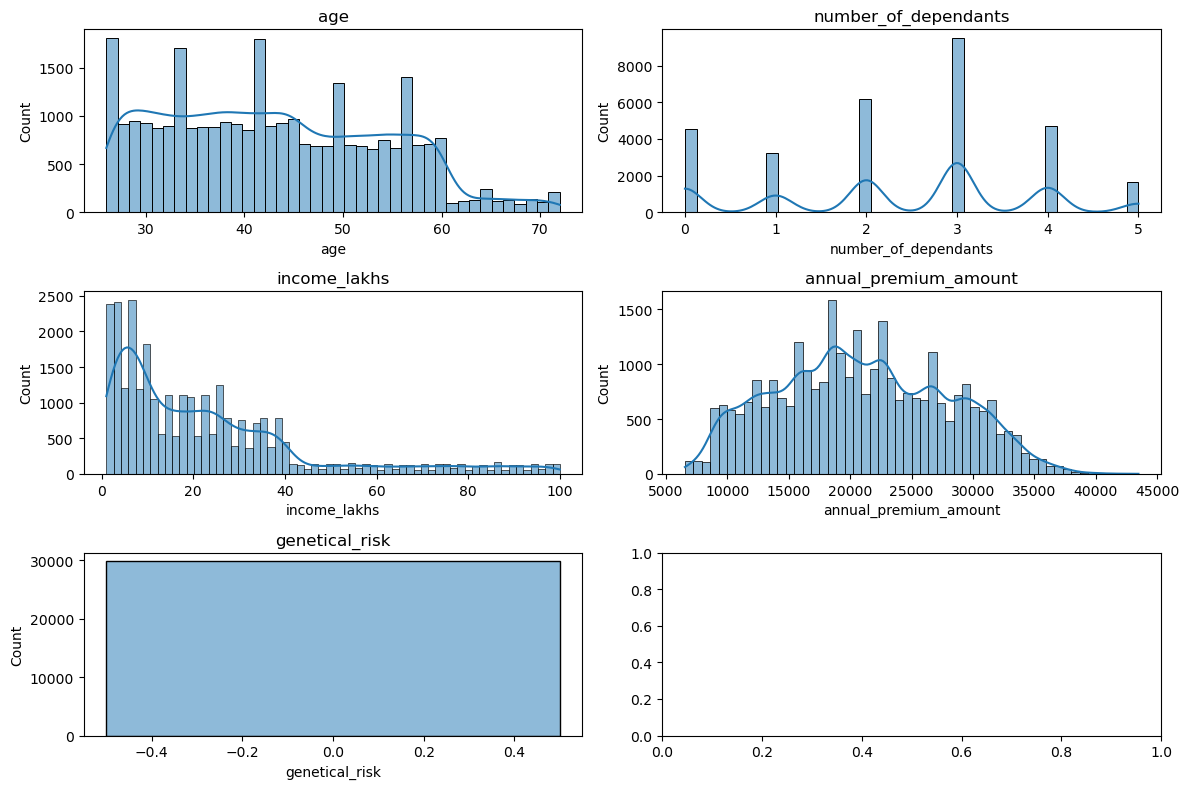

In [47]:
fig, axes = plt.subplots(3,2,figsize = (12,8))
axes = axes.flatten()
for i,col in enumerate(num_columns):
    ax = axes[i]
    sns.histplot(df2[col],kde = True, ax = ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

<Axes: xlabel='age', ylabel='annual_premium_amount'>

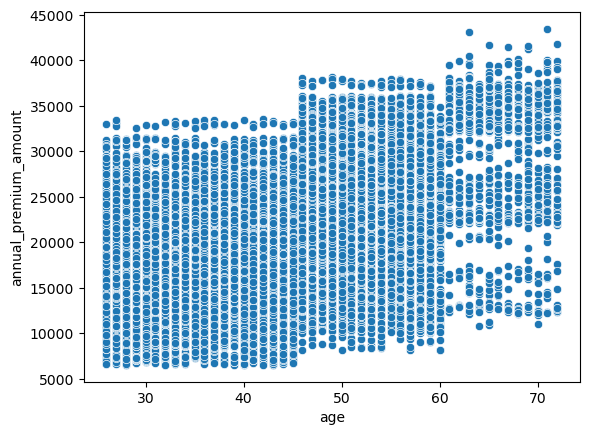

In [48]:
sns.scatterplot(data = df2, x = 'age', y = 'annual_premium_amount')

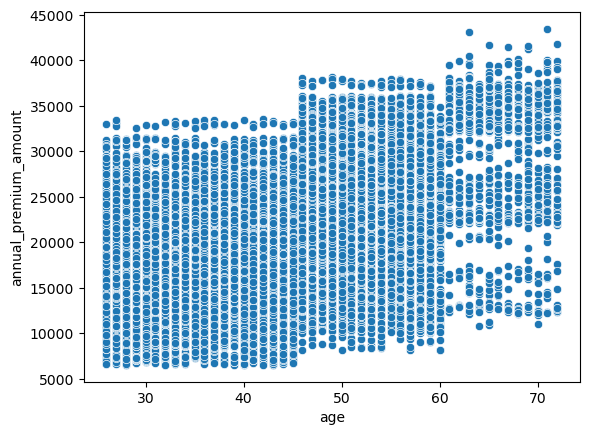

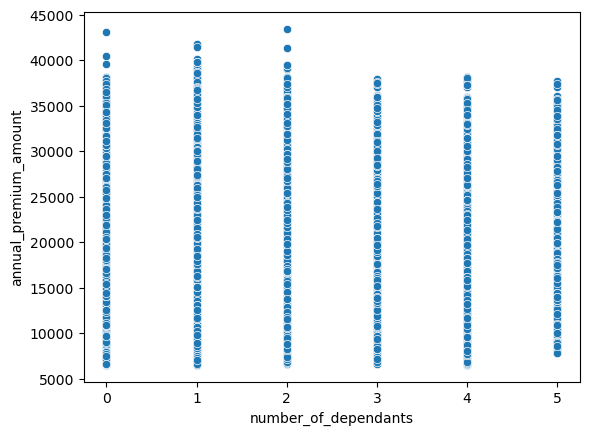

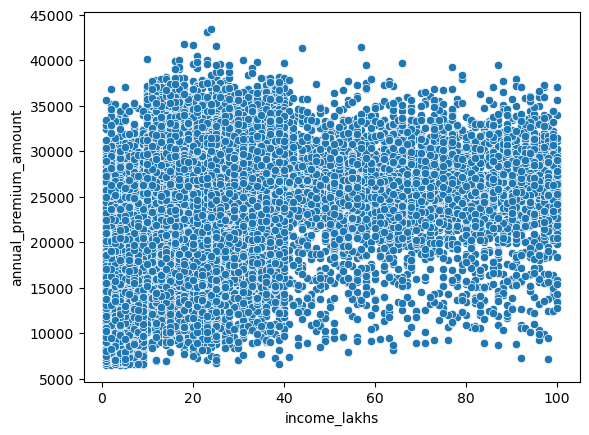

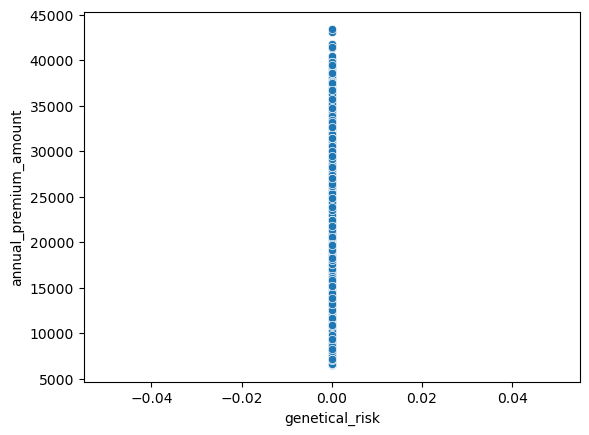

In [49]:
for i in num_columns.drop('annual_premium_amount'):
    sns.scatterplot(data = df2, y = 'annual_premium_amount', x = i)
    plt.show()

In [50]:
cat_columns = df2.select_dtypes(exclude = 'number').columns
cat_columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'income_level', 'medical_history',
       'insurance_plan'],
      dtype='object')

In [51]:
for i in cat_columns:
    print(f'{i}: {df2[i].unique()}')

gender: ['Male' 'Female']
region: ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status: ['Unmarried' 'Married']
bmi_category: ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status: ['No Smoking' 'Regular' 'Occasional' 'Does Not Smoke' 'Not Smoking'
 'Smoking=0']
employment_status: ['Salaried' 'Self-Employed' 'Freelancer']
income_level: ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history: ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan: ['Bronze' 'Silver' 'Gold']


In [52]:
## the smoking status has wrong values lets replace them

In [53]:
smoke = {'Smoking=0':'No Smoking','Does Not Smoke':'No Smoking','Not Smoking':'No Smoking' }
df2['smoking_status'] = df2['smoking_status'].replace(smoke)

In [54]:
for i in cat_columns:
    print(f'{i} : {df2[i].unique()}')

gender : ['Male' 'Female']
region : ['Northwest' 'Southeast' 'Northeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Normal' 'Obesity' 'Overweight' 'Underweight']
smoking_status : ['No Smoking' 'Regular' 'Occasional']
employment_status : ['Salaried' 'Self-Employed' 'Freelancer']
income_level : ['<10L' '10L - 25L' '> 40L' '25L - 40L']
medical_history : ['Diabetes' 'High blood pressure' 'No Disease'
 'Diabetes & High blood pressure' 'Thyroid' 'Heart disease'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid'
 'Diabetes & Heart disease']
insurance_plan : ['Bronze' 'Silver' 'Gold']


In [55]:
cat_columns.shape

(9,)

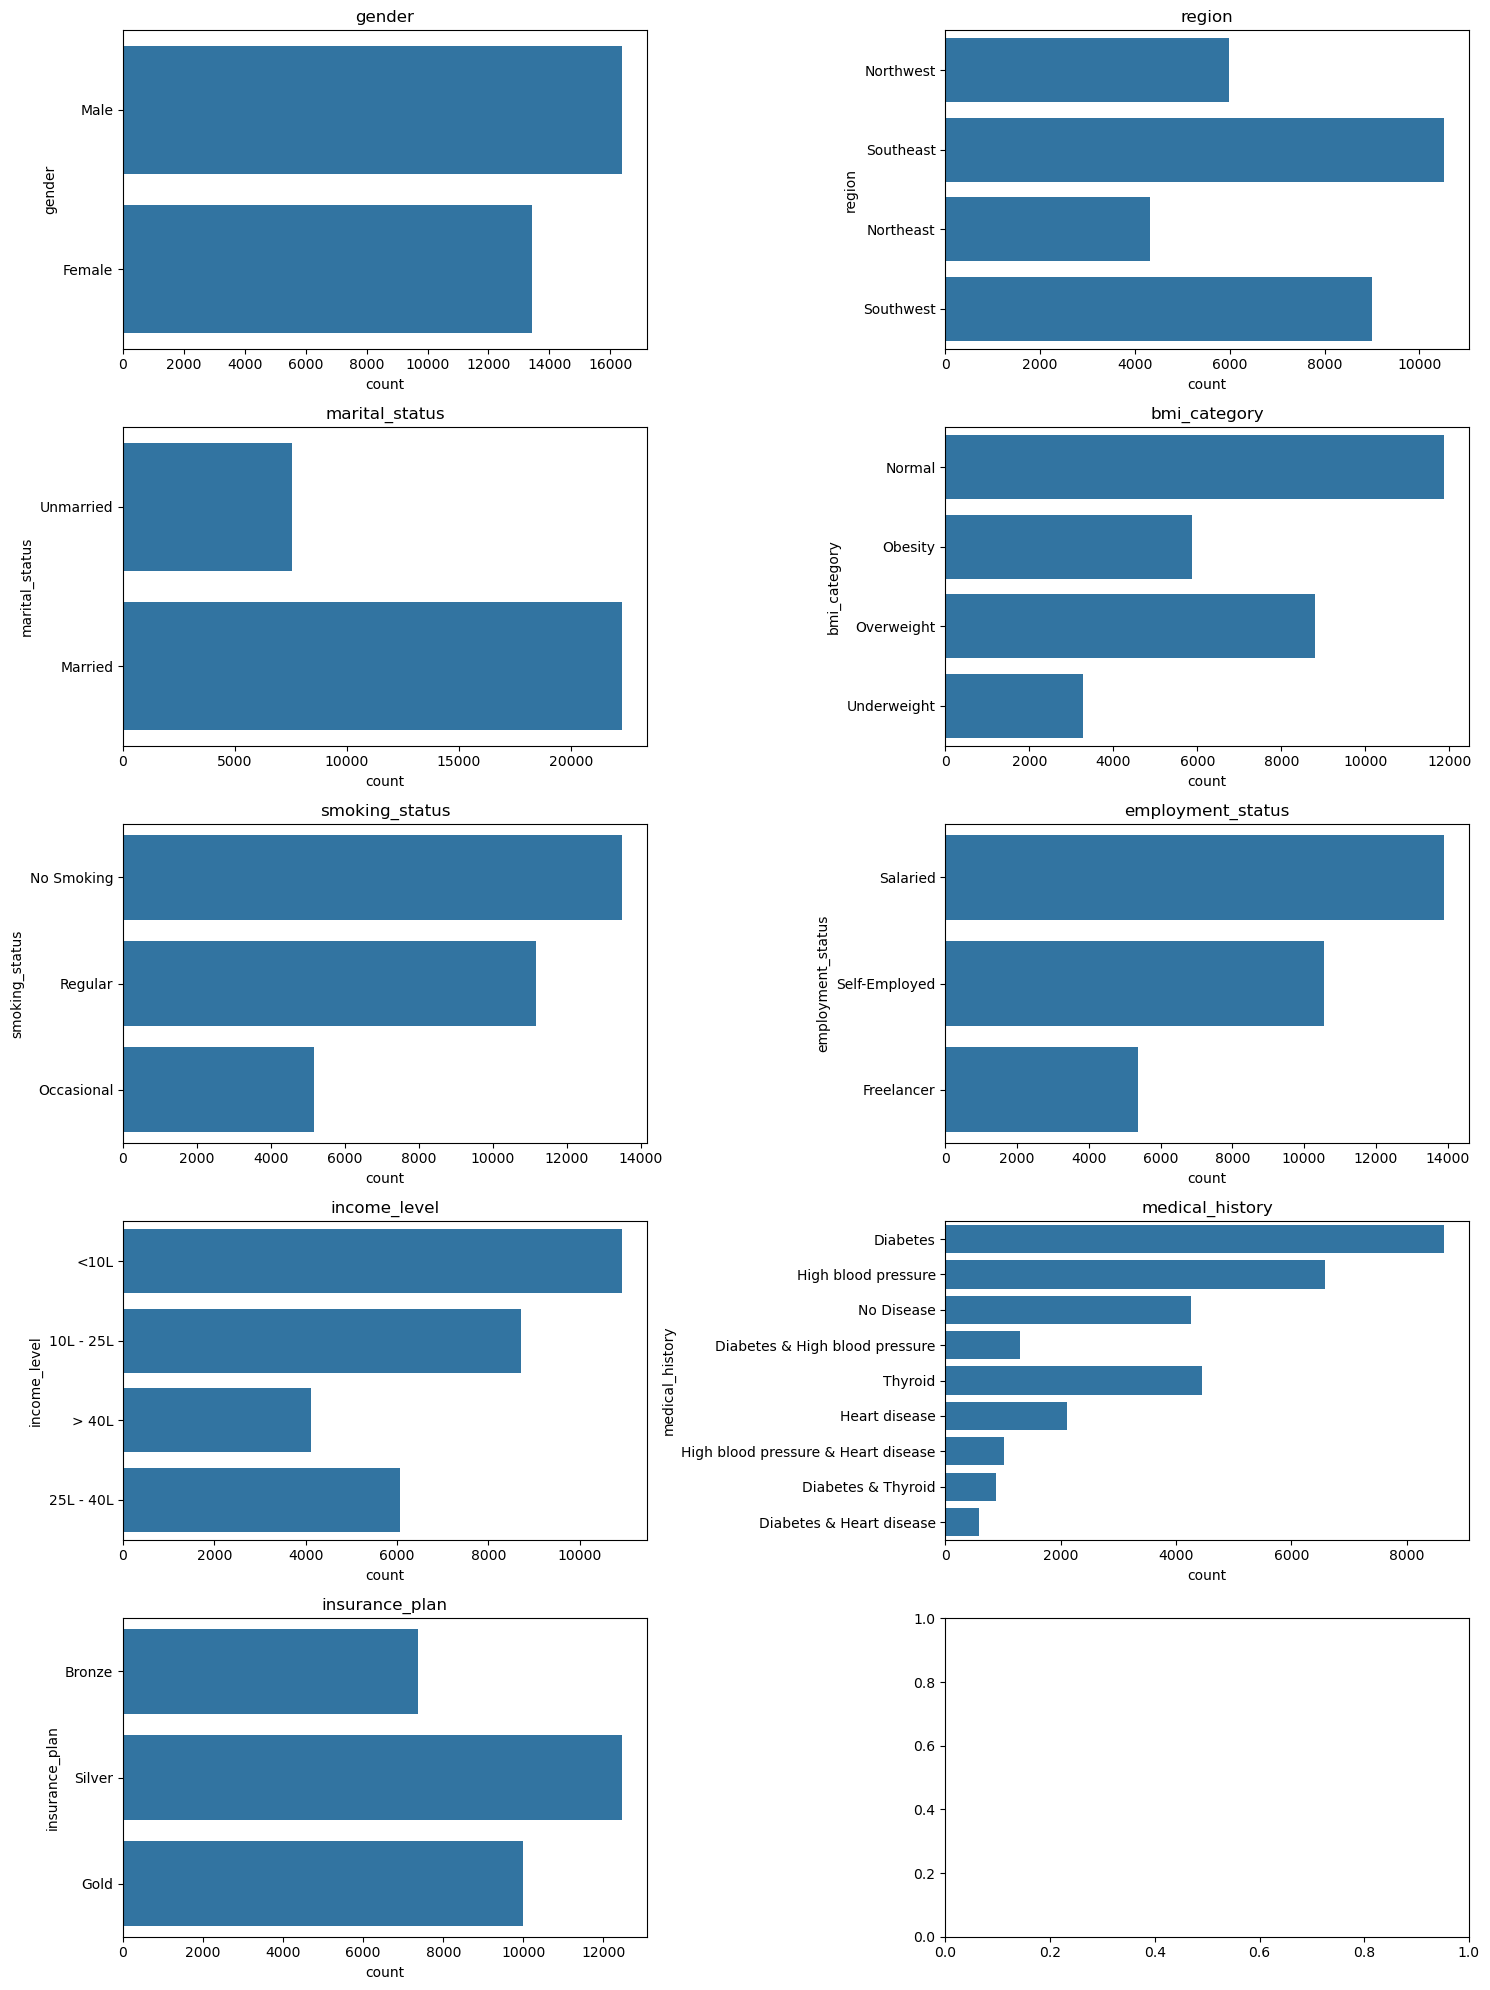

In [56]:
fig, axes = plt.subplots(5,2,figsize = (15,20))
for i,col in enumerate(cat_columns):
    ax = axes[i//2,i%2]
    sns.countplot(df2[col],ax = ax)
    ax.set_title(col)
plt.tight_layout()
plt.show()

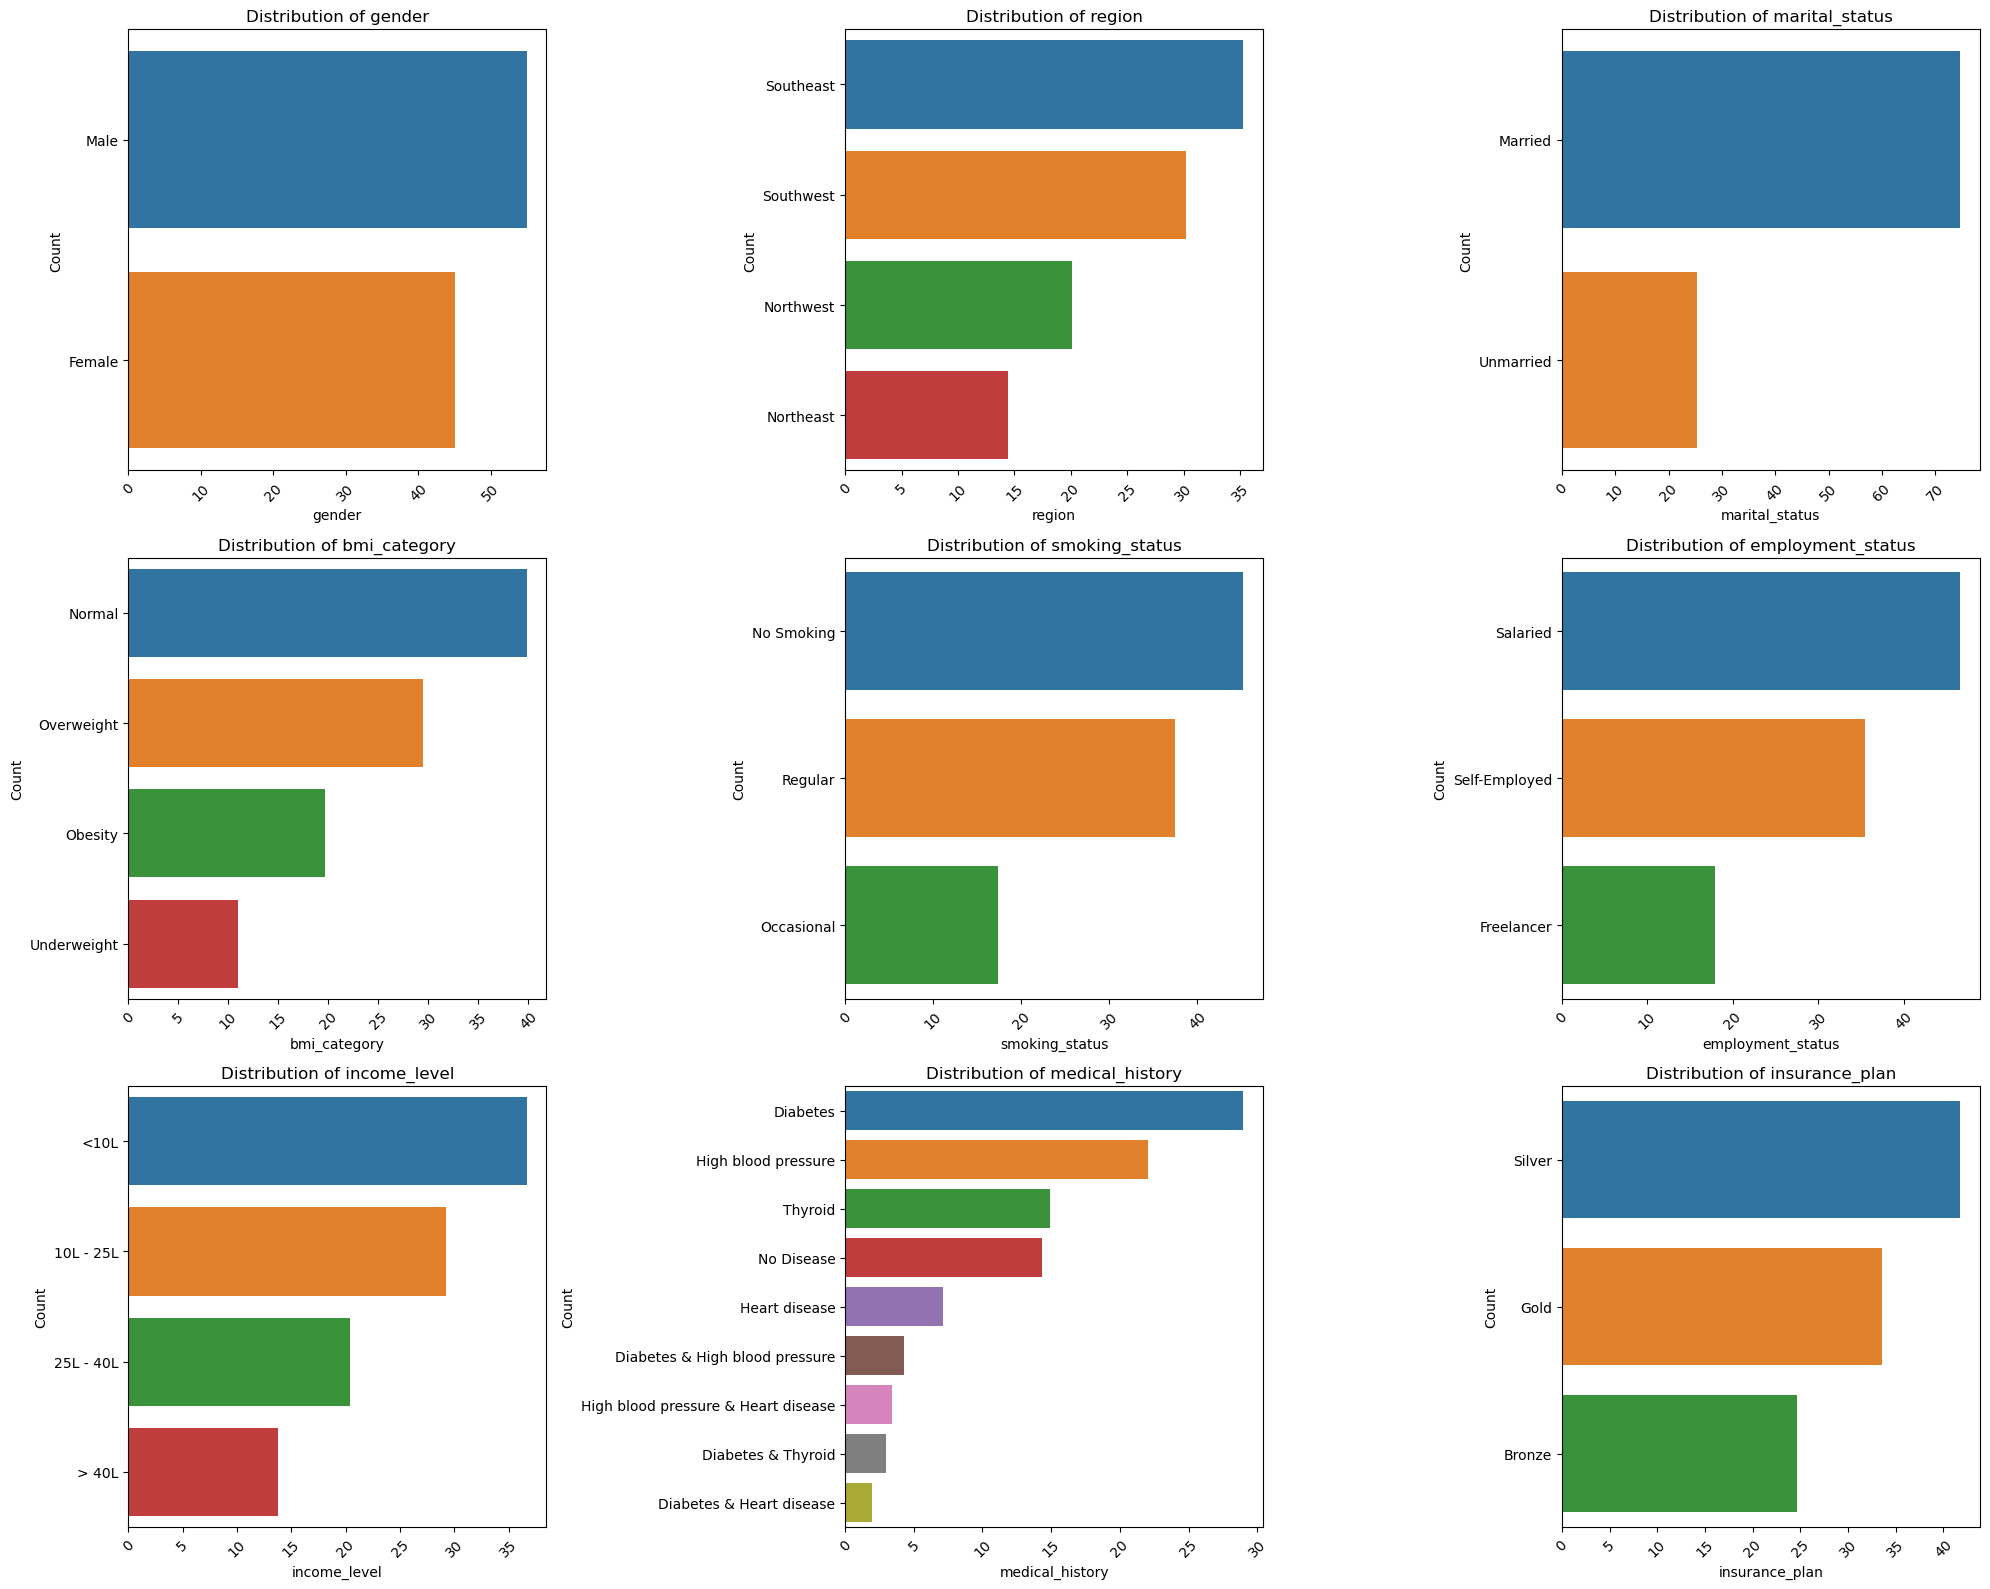

In [57]:


# Create a 3x3 grid (since 9 plots)
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
axes = axes.flatten()  # Flatten to simplify indexing

for i, col in enumerate(cat_columns):
    ax = axes[i]
    
    # Sort categories by count
    sorted_counts = (df2[col].value_counts(normalize = True)*100).sort_values(ascending=False)
    
    # Plot with sorted order
    sns.barplot(y=sorted_counts.index, x=sorted_counts.values,hue = sorted_counts.index, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [58]:
cross = pd.crosstab(df2['income_level'],df2['insurance_plan'])
cross

insurance_plan,Bronze,Gold,Silver
income_level,,,
10L - 25L,799,3554,4354
25L - 40L,301,2631,3142
<10L,6054,527,4341
> 40L,214,3287,618


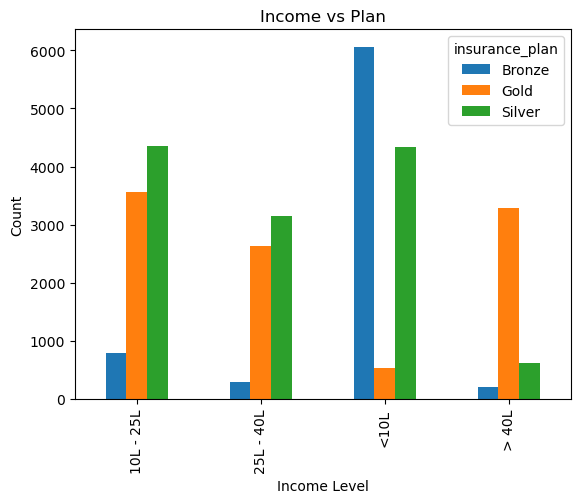

In [59]:
cross.plot(kind = 'bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.xlabel('Income Level')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

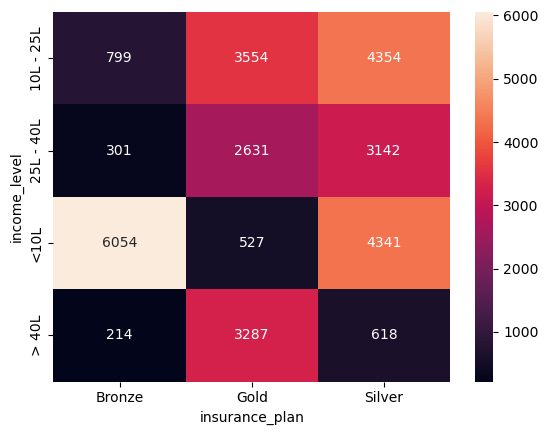

In [60]:
sns.heatmap(cross, annot = True, fmt = 'd')

In [61]:
df2.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk'],
      dtype='object')

In [62]:
df2['medical_history'].unique()

array(['Diabetes', 'High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Thyroid', 'Heart disease',
       'High blood pressure & Heart disease', 'Diabetes & Thyroid',
       'Diabetes & Heart disease'], dtype=object)

In [63]:
# we want to score each disease and create one disease score for each patient
# based on discussion with business, below list of risk scores was finalised

In [64]:
risk_scores = {'diabetes':6, 'heart disease':8, 'high blood pressure':6,'thyroid':5, 'no disease':0,'none':0}

In [65]:
df2['med_new'] = df2['medical_history'].str.lower().str.split('&')

In [66]:
df2['med_new'] = df2['med_new'].apply(lambda lst: [i.strip() for i in lst])

In [67]:
print(df2['med_new'].sample(5))

19622      [diabetes, thyroid]
9530           [heart disease]
1208     [high blood pressure]
7385     [high blood pressure]
12262    [high blood pressure]
Name: med_new, dtype: object


In [68]:
def tot_risk_score(lst):
    tot = 0
    for i in lst:
        tot += risk_scores[i]
    return tot

In [69]:
df2['med_new'].head()

0               [diabetes]
1               [diabetes]
2    [high blood pressure]
3             [no disease]
4               [diabetes]
Name: med_new, dtype: object

In [70]:
df2['total_risk_score'] = df2['med_new'].apply(tot_risk_score)

In [71]:
df2.sample(10)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,med_new,total_risk_score
24235,28,Male,Southeast,Unmarried,2,Obesity,Occasional,Self-Employed,> 40L,73,High blood pressure,Bronze,14328,0,[high blood pressure],6
2033,55,Female,Northeast,Unmarried,1,Underweight,No Smoking,Salaried,10L - 25L,18,No Disease,Gold,24893,0,[no disease],0
12726,32,Female,Southeast,Unmarried,1,Underweight,Regular,Salaried,<10L,1,Diabetes & Thyroid,Bronze,14883,0,"[diabetes, thyroid]",11
10557,27,Male,Southwest,Married,3,Normal,Regular,Salaried,<10L,4,Diabetes,Bronze,11872,0,[diabetes],6
7958,59,Male,Southeast,Married,3,Overweight,Regular,Self-Employed,<10L,4,Diabetes,Silver,23992,0,[diabetes],6
18195,26,Male,Southwest,Married,5,Normal,No Smoking,Freelancer,25L - 40L,38,Diabetes & High blood pressure,Bronze,10986,0,"[diabetes, high blood pressure]",12
11749,37,Male,Southwest,Married,4,Normal,Regular,Self-Employed,> 40L,75,Diabetes,Silver,18239,0,[diabetes],6
18552,50,Male,Southeast,Married,3,Overweight,Regular,Salaried,10L - 25L,10,Diabetes,Bronze,15461,0,[diabetes],6
2441,38,Female,Southwest,Married,3,Overweight,Occasional,Self-Employed,<10L,6,Diabetes,Bronze,11770,0,[diabetes],6
10259,27,Female,Southeast,Married,2,Underweight,No Smoking,Salaried,<10L,7,Diabetes,Bronze,9210,0,[diabetes],6


In [72]:
df2.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk,total_risk_score
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.0,29822.000000
mean,43.094896,2.387734,23.226343,20900.689223,0.0,5.969217
std,11.042430,1.420644,22.455408,6928.192115,0.0,3.361170
min,26.000000,0.000000,1.000000,6538.000000,0.0,0.000000
25%,34.000000,1.000000,7.000000,15705.250000,0.0,5.000000
50%,42.000000,3.000000,17.000000,20495.500000,0.0,6.000000
75%,52.000000,3.000000,32.000000,26360.000000,0.0,6.000000
max,72.000000,5.000000,100.000000,43471.000000,0.0,14.000000


In [73]:
max_risk = df2['total_risk_score'].max()
min_risk = df2['total_risk_score'].min()

In [74]:
df2['norm_risk_score'] = (df2['total_risk_score'] - min_risk)/(max_risk - min_risk)

In [75]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,med_new,total_risk_score,norm_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,[diabetes],6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,[diabetes],6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,[high blood pressure],6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,[no disease],0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0,[diabetes],6,0.428571


In [76]:
df2 = df2.drop(columns = 'med_new')

In [77]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,norm_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,Bronze,9053,0,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,Bronze,16339,0,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,Silver,18164,0,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,Gold,20303,0,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,Bronze,15610,0,6,0.428571


In [78]:
# now lets move to insurance plan

In [79]:
df2['insurance_plan'].unique()

array(['Bronze', 'Silver', 'Gold'], dtype=object)

In [80]:
plans = {'Bronze':1, 'Silver':2, 'Gold':3}

In [81]:
df2['insurance_plan'] = df2['insurance_plan'].map(plans)

In [82]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,norm_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,<10L,6,Diabetes,1,9053,0,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,<10L,6,Diabetes,1,16339,0,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,10L - 25L,20,High blood pressure,2,18164,0,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,> 40L,77,No Disease,3,20303,0,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,10L - 25L,14,Diabetes,1,15610,0,6,0.428571


In [83]:
df2['income_level'].unique()

array(['<10L', '10L - 25L', '> 40L', '25L - 40L'], dtype=object)

In [84]:
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L':2, '25L - 40L':3, '> 40L':4 })

In [85]:
df2.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,norm_risk_score
0,26,Male,Northwest,Unmarried,0,Normal,No Smoking,Salaried,1,6,Diabetes,1,9053,0,6,0.428571
1,29,Female,Southeast,Married,2,Obesity,Regular,Salaried,1,6,Diabetes,1,16339,0,6,0.428571
2,49,Female,Northeast,Married,2,Normal,No Smoking,Self-Employed,2,20,High blood pressure,2,18164,0,6,0.428571
3,30,Female,Southeast,Married,3,Normal,No Smoking,Salaried,4,77,No Disease,3,20303,0,0,0.000000
4,56,Male,Northeast,Married,3,Obesity,Occasional,Self-Employed,2,14,Diabetes,1,15610,0,6,0.428571


In [86]:
df2.dtypes

age                        int64
gender                    object
region                    object
marital_status            object
number_of_dependants       int64
bmi_category              object
smoking_status            object
employment_status         object
income_level               int64
income_lakhs               int64
medical_history           object
insurance_plan             int64
annual_premium_amount      int64
genetical_risk             int64
total_risk_score           int64
norm_risk_score          float64
dtype: object

In [87]:
df2.columns

Index(['age', 'gender', 'region', 'marital_status', 'number_of_dependants',
       'bmi_category', 'smoking_status', 'employment_status', 'income_level',
       'income_lakhs', 'medical_history', 'insurance_plan',
       'annual_premium_amount', 'genetical_risk', 'total_risk_score',
       'norm_risk_score'],
      dtype='object')

In [88]:
df2.select_dtypes(exclude = 'number').columns

Index(['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status',
       'employment_status', 'medical_history'],
      dtype='object')

In [89]:
col_for_hot_enc = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status','employment_status']

In [90]:
df3 = pd.get_dummies(df2, columns = col_for_hot_enc, drop_first = True,dtype = int).copy()

In [91]:
df3.head()

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,total_risk_score,norm_risk_score,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,Diabetes,1,9053,0,6,0.428571,...,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,Diabetes,1,16339,0,6,0.428571,...,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,High blood pressure,2,18164,0,6,0.428571,...,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,No Disease,3,20303,0,0,0.000000,...,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,Diabetes,1,15610,0,6,0.428571,...,0,0,0,1,0,0,1,0,0,1


In [92]:
df3 = df3.drop(columns = ['medical_history','total_risk_score'])

In [93]:
df3.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,norm_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,26,0,1,6,1,9053,0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,29,2,1,6,1,16339,0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,49,2,2,20,2,18164,0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,30,3,4,77,3,20303,0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,56,3,2,14,1,15610,0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [94]:
cm = df3.corr()
cm

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,norm_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
age,1.000000,-0.017614,0.033455,0.024253,0.310446,0.484715,NaN,0.002473,-0.003699,0.001752,-0.002130,-0.003622,-0.123857,0.014732,0.017585,0.005224,-0.053572,-0.126481,-0.198537,0.270621
number_of_dependants,-0.017614,1.000000,-0.000009,-0.000640,0.010334,0.015969,NaN,0.106168,-0.000594,-0.002981,0.000732,0.007047,-0.777352,0.019413,0.014560,-0.021186,0.011848,0.013306,0.012497,-0.015319
income_level,0.033455,-0.000009,1.000000,0.906027,0.575543,0.457965,NaN,0.009162,0.087234,-0.003207,0.001624,0.008060,-0.008038,-0.013072,0.000403,0.009439,-0.008517,0.027486,-0.153555,0.158281
income_lakhs,0.024253,-0.000640,0.906027,1.000000,0.491785,0.385215,NaN,0.002320,0.064060,-0.004417,0.000914,0.006266,-0.005109,-0.010316,0.001635,0.004484,-0.002957,0.018637,-0.115155,0.121798
insurance_plan,0.310446,0.010334,0.575543,0.491785,1.000000,0.882571,NaN,0.001329,0.069102,-0.000996,0.006580,-0.006797,-0.053047,0.014033,0.025969,-0.014648,-0.029196,-0.017796,-0.152740,0.185159
annual_premium_amount,0.484715,0.015969,0.457965,0.385215,0.882571,1.000000,NaN,0.209361,0.132898,-0.004529,0.007190,-0.005766,-0.103286,0.188450,0.086748,-0.053967,-0.059392,0.136671,-0.179511,0.226210
genetical_risk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
norm_risk_score,0.002473,0.106168,0.009162,0.002320,0.001329,0.209361,NaN,1.000000,-0.005953,-0.010381,0.002480,0.005633,-0.140899,-0.010069,-0.004903,0.006440,0.005484,0.003338,-0.009321,0.014835
gender_Male,-0.003699,-0.000594,0.087234,0.064060,0.069102,0.132898,NaN,-0.005953,1.000000,-0.003620,-0.004893,0.004782,0.001761,-0.020570,0.103029,-0.029880,-0.096120,0.372381,0.004947,0.002606
region_Northwest,0.001752,-0.002981,-0.003207,-0.004417,-0.000996,-0.004529,NaN,-0.010381,-0.003620,1.000000,-0.369870,-0.329590,0.001498,0.001041,0.000390,-0.007454,-0.000612,0.001156,0.000872,0.000298


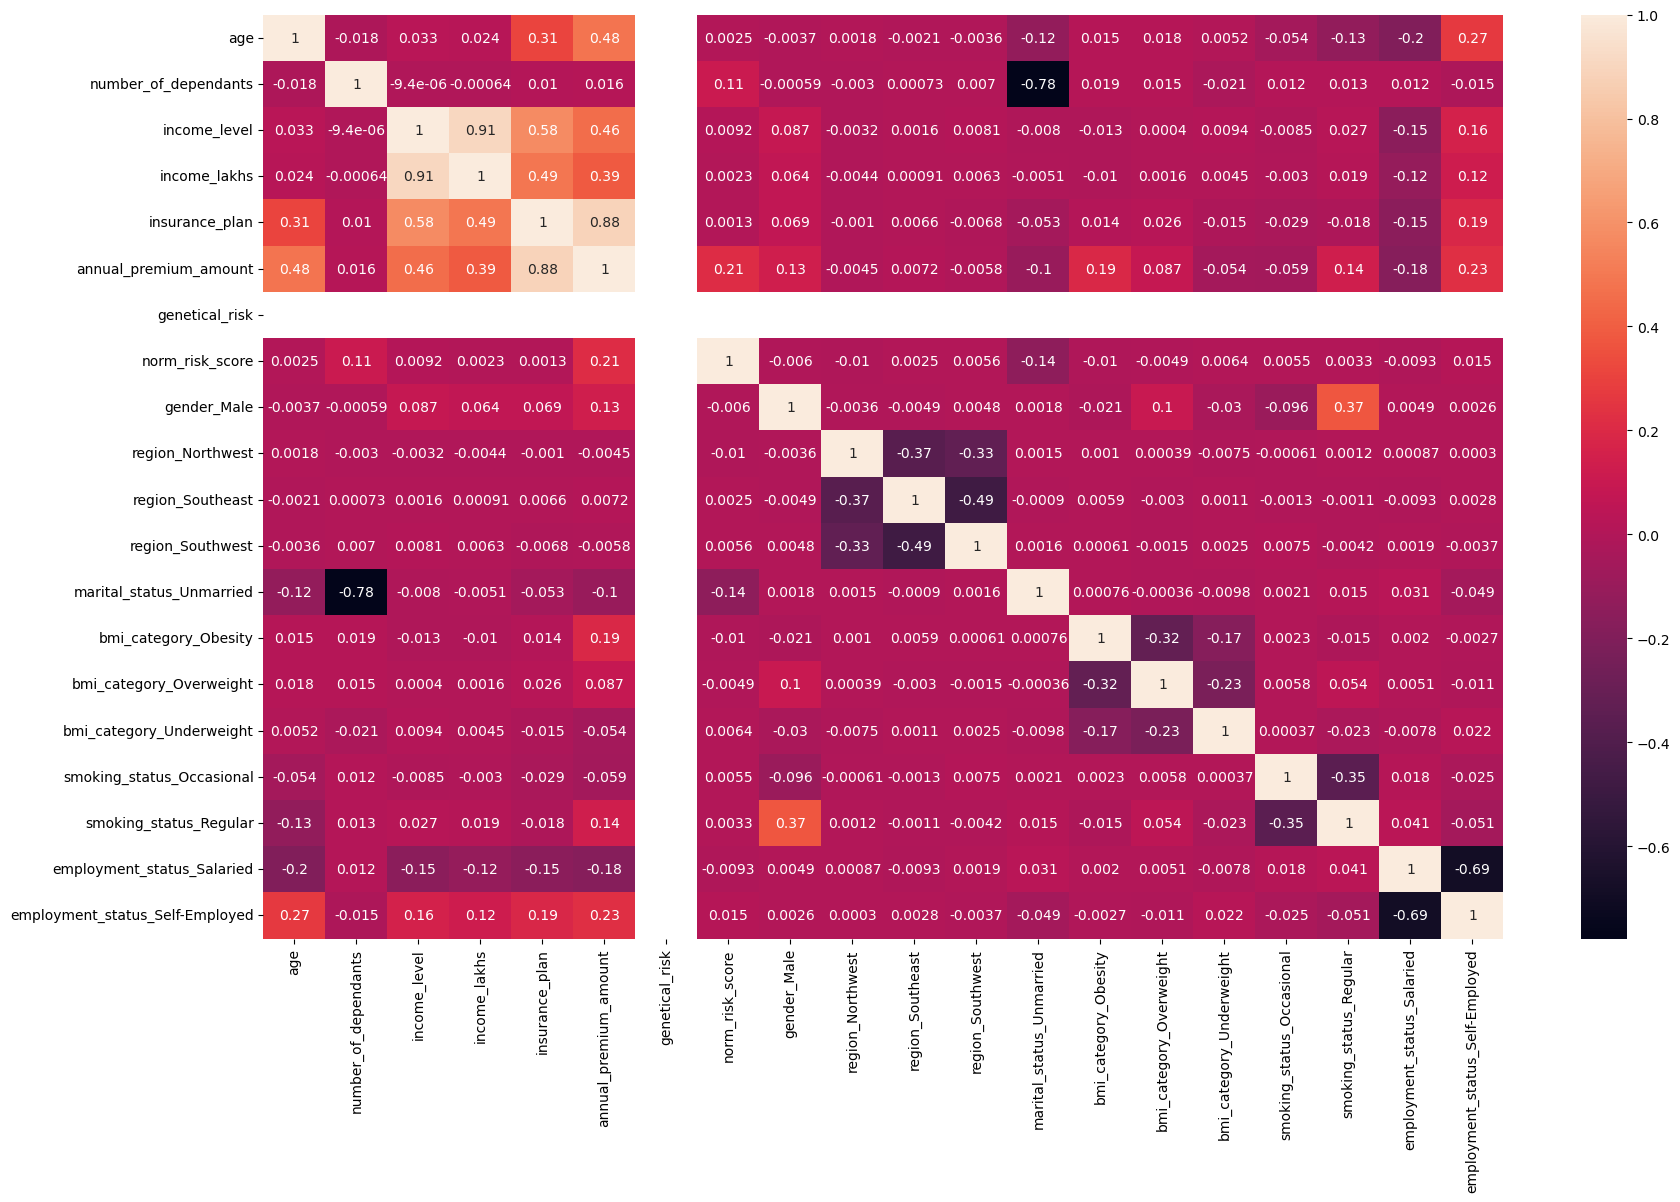

In [95]:
plt.figure(figsize = (20,12))
sns.heatmap(cm,annot = True)
plt.show()

In [96]:
df3.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'genetical_risk',
       'norm_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

In [97]:
X = df3.drop(columns = 'annual_premium_amount')
y = df3['annual_premium_amount']

In [98]:
# scaling the features before using vif for feature selection

In [99]:
cols_to_scale = ['age', 'number_of_dependants', 'income_level', 'income_lakhs','insurance_plan','genetical_risk']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

In [100]:
X.head()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,norm_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.000000,0.050505,0.0,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.000000,0.050505,0.0,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.333333,0.191919,0.5,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,1.000000,0.767677,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.333333,0.131313,0.0,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


In [101]:
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,norm_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.0,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000,29822.000000
mean,0.371628,0.477547,0.371225,0.224509,0.544112,0.0,0.426373,0.549125,0.200691,0.352693,0.301992,0.253336,0.196835,0.295051,0.110087,0.173228,0.374656,0.466132,0.354269
std,0.240053,0.284129,0.351111,0.226822,0.379009,0.0,0.240084,0.497589,0.400524,0.477816,0.459129,0.434929,0.397613,0.456073,0.313003,0.378450,0.484042,0.498860,0.478299
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.173913,0.200000,0.000000,0.060606,0.500000,0.0,0.357143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.347826,0.600000,0.333333,0.161616,0.500000,0.0,0.428571,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.565217,0.600000,0.666667,0.313131,1.000000,0.0,0.428571,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [102]:
def get_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data,i) for i in range(data.shape[1])]
    return vif_df

In [103]:
get_vif(X)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.921783
1,number_of_dependants,6.278938
2,income_level,13.890522
3,income_lakhs,11.185596
4,insurance_plan,5.271297
5,genetical_risk,NaN
6,norm_risk_score,3.810619
7,gender_Male,2.599098
8,region_Northwest,2.123965
9,region_Southeast,2.980842


In [104]:
# as we can see here, income level and income lakhs have vif> 10
# remove feature iteratively and not in a bunch

In [105]:
get_vif(X.drop(columns = 'income_level'))

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,Column,VIF
0,age,3.863055
1,number_of_dependants,6.278147
2,income_lakhs,2.678102
3,insurance_plan,4.574625
4,genetical_risk,NaN
5,norm_risk_score,3.808345
6,gender_Male,2.591439
7,region_Northwest,2.123277
8,region_Southeast,2.979899
9,region_Southwest,2.708641


In [106]:
# as we can see now the vif are well below 5, we need not remove any other features

In [107]:
X_reduced = X.drop(columns = 'income_level')

In [108]:
X_reduced.head()

,age,number_of_dependants,income_lakhs,insurance_plan,genetical_risk,norm_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,0.000000,0.0,0.050505,0.0,0.0,0.428571,1,1,0,0,1,0,0,0,0,0,1,0
1,0.065217,0.4,0.050505,0.0,0.0,0.428571,0,0,1,0,0,1,0,0,0,1,1,0
2,0.500000,0.4,0.191919,0.5,0.0,0.428571,0,0,0,0,0,0,0,0,0,0,0,1
3,0.086957,0.6,0.767677,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,1,0
4,0.652174,0.6,0.131313,0.0,0.0,0.428571,1,0,0,0,0,1,0,0,1,0,0,1


### Model Training

In [109]:
X_train,X_test, y_train,y_test = train_test_split(X_reduced,y,test_size = .3,random_state = 3)

In [110]:
print(X_train.shape)
print(X_test.shape)

(20875, 18)
(8947, 18)


In [111]:
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [112]:
lr_model.score(X_test,y_test)

0.9530278975411131

In [113]:
#to check overfitting lets see score on train as well

In [114]:
lr_model.score(X_train,y_train)

0.9537499160813925

In [115]:
# these are almost same, so our model is not overfitting

In [116]:
lr_model.coef_

array([ 6.97475824e+03, -1.22596021e+03, -7.84006359e+02,  1.48430803e+04,
        2.27373675e-12,  6.06057610e+03,  3.80716697e+01, -5.01107223e+01,
       -1.00660479e+01,  5.84110886e+00, -6.17613275e+02,  3.94510033e+03,
        1.97826846e+03,  6.19428382e+02,  8.35293773e+02,  2.80509429e+03,
       -3.69520498e+01,  2.64690516e+02])

In [117]:
lr_model_coef_df = pd.DataFrame({'Feature':X_train.columns, 'Coef': lr_model.coef_})

In [118]:
lr_model_coef_df

,Feature,Coef
0,age,6.974758e+03
1,number_of_dependants,-1.225960e+03
2,income_lakhs,-7.840064e+02
3,insurance_plan,1.484308e+04
4,genetical_risk,2.273737e-12
5,norm_risk_score,6.060576e+03
6,gender_Male,3.807167e+01
7,region_Northwest,-5.011072e+01
8,region_Southeast,-1.006605e+01
9,region_Southwest,5.841109e+00


<Axes: xlabel='Feature'>

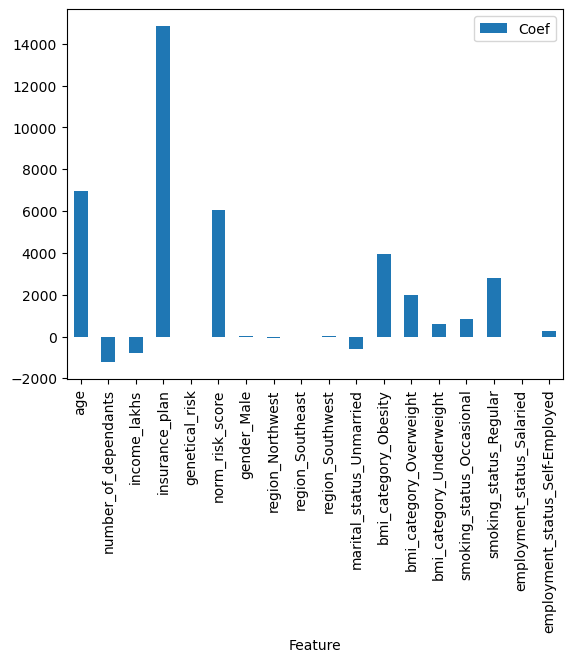

In [119]:
lr_model_coef_df.plot(x = 'Feature',kind= 'bar')

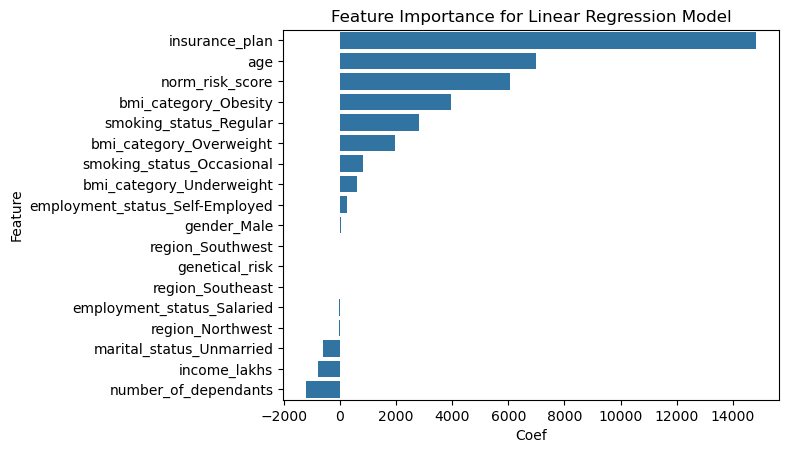

In [120]:
sns.barplot(data = lr_model_coef_df.sort_values(by = 'Coef',ascending = False),y = 'Feature',x = 'Coef')
plt.title('Feature Importance for Linear Regression Model')
plt.show()

In [121]:
rg_model = Ridge()
rg_model.fit(X_train,y_train)
rg_model.score(X_test,y_test)

0.9530276670356765

In [122]:
ls_model = Lasso()
ls_model.fit(X_train,y_train)
ls_model.score(X_test,y_test)

0.9530111824530362

In [123]:
xg_model = XGBRegressor()

In [124]:
xg_model.fit(X_train,y_train)
xg_model.score(X_test,y_test)

0.9980090260505676

In [125]:
xg_model.score(X_train,y_train)

0.9986661672592163

In [126]:
y_lr_pred = lr_model.predict(X_test)
y_xg_pred = xg_model.predict(X_test)

In [127]:
print(f'Log Reg r2 = {r2_score(y_test,y_lr_pred)}, rmse = {root_mean_squared_error(y_test,y_lr_pred)}')
print(f'XGBoost r2 = {r2_score(y_test,y_xg_pred)}, rmse = {root_mean_squared_error(y_test,y_xg_pred)}')


Log Reg r2 = 0.9530278975411131, rmse = 1493.4088853324454
XGBoost r2 = 0.9980090260505676, rmse = 307.4616577044523


In [128]:
#So XGBoost is the clearly better model here

### Hyperparameter Tuning

In [129]:
param_grid = {'n_estimators': [20,40,50],
             'learning_rate': [.01,.1,.2],
             'max_depth': [3,4,5]}
random_search = RandomizedSearchCV(XGBRegressor(),param_grid,n_iter = 10,cv = 3,scoring = 'r2')
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50]},
                   scoring='r2')

In [130]:
random_search.best_score_

0.9980033834775289

In [131]:
random_search.best_params_

{'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.2}

In [132]:
best_model = random_search.best_estimator_

In [133]:
best_model.feature_importances_

array([4.4732165e-02, 1.7290789e-05, 2.3211596e-05, 8.4305185e-01,
       0.0000000e+00, 2.8724432e-02, 2.5265459e-05, 2.4286654e-05,
       1.4820242e-05, 2.0267144e-05, 2.1067533e-05, 3.1825069e-02,
       1.7953161e-02, 1.7472773e-03, 4.3331808e-03, 2.7428936e-02,
       3.4303102e-05, 2.3405411e-05], dtype=float32)

In [134]:
df_feat_imp = pd.DataFrame()
df_feat_imp['columns'] = X_train.columns
df_feat_imp['feature_importances'] = best_model.feature_importances_

In [135]:
df_feat_imp = df_feat_imp.rename(columns = {'columns':'features','feature_importances':'importance'})

In [136]:
df_feat_imp

,features,importance
0,age,0.044732
1,number_of_dependants,0.000017
2,income_lakhs,0.000023
3,insurance_plan,0.843052
4,genetical_risk,0.000000
5,norm_risk_score,0.028724
6,gender_Male,0.000025
7,region_Northwest,0.000024
8,region_Southeast,0.000015
9,region_Southwest,0.000020


<Axes: xlabel='importance', ylabel='features'>

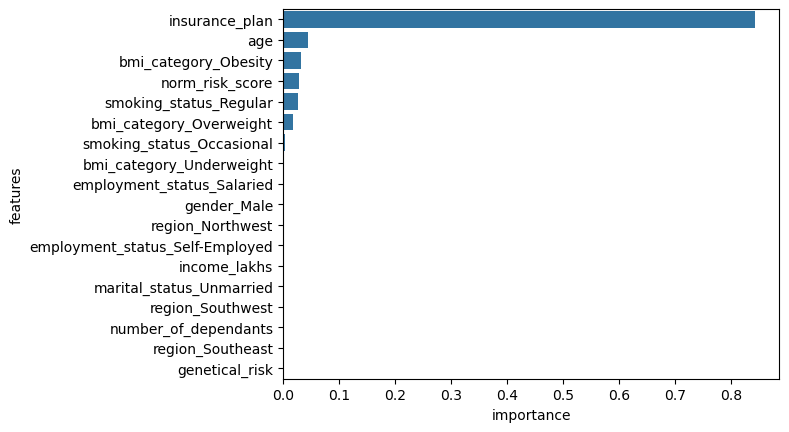

In [137]:
sns.barplot(data = df_feat_imp.sort_values(by = 'importance',ascending = False), y= 'features',x = 'importance')

### Error Analysis

In [138]:
y_pred = best_model.predict(X_test)
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

In [139]:
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})

In [140]:
results_df.head()

,actual,predicted,diff,diff_pct
4777,16615,16645.746094,30.746094,0.185050
21150,29515,29020.597656,-494.402344,-1.675088
4146,27589,27038.437500,-550.562500,-1.995587
970,14930,15093.161133,163.161133,1.092841
6198,20779,20565.251953,-213.748047,-1.028673


In [141]:
results_df.describe()

,actual,predicted,diff,diff_pct
count,8947.000000,8947.000000,8947.000000,8947.000000
mean,20903.957528,20904.539062,0.579154,0.067514
std,6891.011948,6868.127930,303.893906,1.769579
min,6568.000000,7192.770020,-1292.687500,-7.338185
25%,15744.000000,15606.220703,-245.371094,-1.187548
50%,20419.000000,20565.251953,-1.662109,-0.009477
75%,26271.000000,26537.041016,253.294922,1.234640
max,40138.000000,40062.441406,848.429688,9.512333


In [142]:
# As we can see, the error percentage has dropped 9.5 max, from 87 percent previously. So our model preforms well for age group > 25

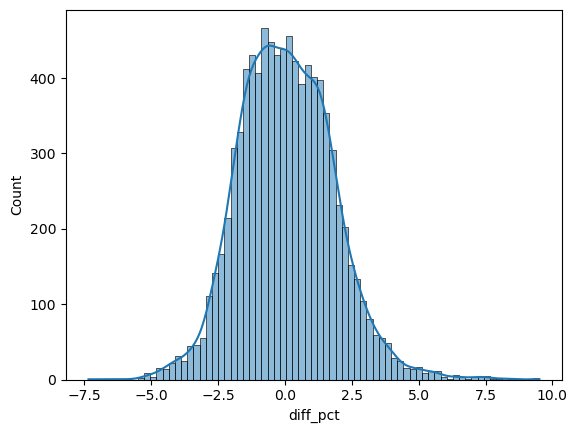

In [143]:
sns.histplot(results_df['diff_pct'],kde =True)
plt.show()

In [144]:
# After discussing with business, we came to a threshold of 10 percent. We have to try and contain the error within 10 percent'

In [145]:
extreme_error_threshold = 10
extreme_results_df = results_df[abs(results_df['diff_pct'])>extreme_error_threshold]

In [146]:
extreme_results_df.shape

(0, 4)

In [147]:
results_df.shape

(8947, 4)

In [148]:
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

0.0

In [149]:
# So from 30 percent previously, now it is 0

In [150]:
results_df[abs(results_df['diff_pct'])>50].shape

(0, 4)

In [151]:
# XGBoost performance for this age group(>25) is good and no more changes are required

### Export the model

In [152]:
from joblib import dump

In [154]:
dump(best_model,'Artifacts/model_rest.joblib')

['Artifacts/model_rest.joblib']

In [155]:
scaler_with_cols = {'scaler':scaler, 'cols_to_scale':cols_to_scale}

In [156]:
dump(scaler_with_cols,'Artifacts/scaler_rest.joblib')

['Artifacts/scaler_rest.joblib']